In [1]:
import sys
sys.path.append('../marketools')

In [2]:
from marketools import Stock, store_data
import numpy as np
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [28, 3]
sn.set()
store_data()

In [3]:
ticker = 'WIG'
stagnetion_delta = 0.5
window = 3

In [4]:
stk = Stock(ticker)
data = stk.ohlc.drop(['High', 'Low', 'Volume'], axis=1)

data['Change%'] = 100 * (data['Close'] - data['Open']) / data['Open']

"""
0 - bearish
1 - bullish
2 - stagnetion
"""
data['Market'] = 2
data.loc[data['Change%'] > stagnetion_delta, 'Market'] = 1
data.loc[data['Change%'] < -stagnetion_delta, 'Market'] = 0

data['Market state'] = 0

for w in range(1, window+1):
    data[f'Market {w}d before'] = data['Market'].shift(w)
    data['Market state'] += pow(3, w-1) * data[f'Market {w}d before']
    
data.drop(data.head(window).index,inplace=True)
data['Market state'] = data['Market state'].astype('int')


data_valid = data['2019-01-01':]
data = data['2001-01-01':'2018-12-31']
data

,Open,Close,Change%,Market,Market state,Market 1d before,Market 2d before,Market 3d before
Date,,,,,,,,
2001-01-02,17567.90,17672.80,0.597112,1,20,2.0,0.0,2.0
2001-01-03,17520.70,17506.10,-0.083330,2,7,1.0,2.0,0.0
2001-01-04,17673.00,17875.90,1.148079,1,23,2.0,1.0,2.0
2001-01-05,17862.30,17509.30,-1.976229,0,16,1.0,2.0,1.0
2001-01-08,17276.70,17119.30,-0.911054,0,21,0.0,1.0,2.0
...,...,...,...,...,...,...,...,...
2018-12-19,58695.35,59223.65,0.900071,1,19,1.0,0.0,2.0
2018-12-20,58646.01,58349.03,-0.506394,0,4,1.0,1.0,0.0
2018-12-21,58188.73,57331.35,-1.473447,0,12,0.0,1.0,1.0


In [5]:
data_valid['Predicted market'] = np.nan
data_valid

,Open,Close,Change%,Market,Market state,Market 1d before,Market 2d before,Market 3d before,Predicted market
Date,,,,,,,,,
2019-01-02,57494.06,58290.21,1.384752,1,1,1.0,0.0,0.0,NaN
2019-01-03,58055.17,57192.42,-1.486086,0,4,1.0,1.0,0.0,NaN
2019-01-04,57489.96,57947.51,0.795878,1,12,0.0,1.0,1.0,NaN
2019-01-07,58270.90,58971.42,1.202178,1,10,1.0,0.0,1.0,NaN
2019-01-08,58884.37,58906.77,0.038041,2,4,1.0,1.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...
2021-02-19,58824.24,58712.53,-0.189905,2,9,0.0,0.0,1.0,NaN
2021-02-22,58486.64,58157.32,-0.563069,0,2,2.0,0.0,0.0,NaN
2021-02-23,58383.46,57029.17,-2.319647,0,6,0.0,2.0,0.0,NaN


In [6]:
transition_matrix = np.zeros((3, 3**window))
# state[k+1] = transition_matrix.dot(state[k])

for i in range(0, 3**window):
    n = data.loc[(data['Market state'] == i)].shape[0]
    
    for j in range(0, 3):
        if 0 == n:
            transition_matrix[j, i] = 1 / 3
        else:
            transition_matrix[j, i] = data.loc[(data['Market'] == j) & (data['Market state'] == i)].shape[0] / n
        # print(i, '-->', j, ':', transition_matrix[j, i])

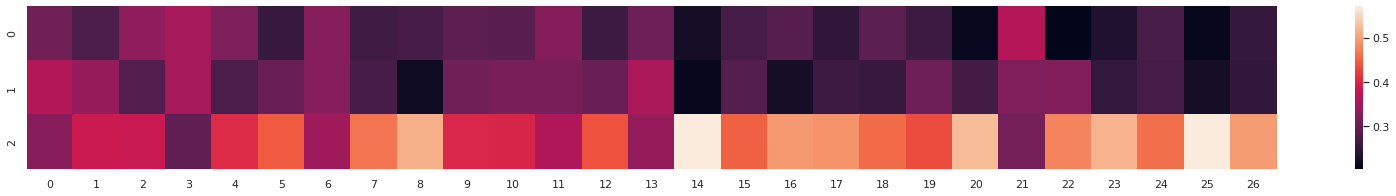

In [7]:
sn.heatmap(transition_matrix)
plt.show()

In [8]:
for index, row in data_valid.iterrows():
    market_state = np.zeros(3**window)
    market_state[int(row['Market state'])] = 1
    data_valid.loc[index, 'Predicted market'] = transition_matrix.dot(market_state).argmax()
    # TODO: check if vector has different values, if not --> none
    
data_valid['Correct prediction'] = data_valid['Market'] == data_valid['Predicted market']
data_valid

,Open,Close,Change%,Market,Market state,Market 1d before,Market 2d before,Market 3d before,Predicted market,Correct prediction
Date,,,,,,,,,,
2019-01-02,57494.06,58290.21,1.384752,1,1,1.0,0.0,0.0,2.0,False
2019-01-03,58055.17,57192.42,-1.486086,0,4,1.0,1.0,0.0,2.0,False
2019-01-04,57489.96,57947.51,0.795878,1,12,0.0,1.0,1.0,2.0,False
2019-01-07,58270.90,58971.42,1.202178,1,10,1.0,0.0,1.0,2.0,False
2019-01-08,58884.37,58906.77,0.038041,2,4,1.0,1.0,0.0,2.0,True
...,...,...,...,...,...,...,...,...,...,...
2021-02-19,58824.24,58712.53,-0.189905,2,9,0.0,0.0,1.0,2.0,True
2021-02-22,58486.64,58157.32,-0.563069,0,2,2.0,0.0,0.0,2.0,False
2021-02-23,58383.46,57029.17,-2.319647,0,6,0.0,2.0,0.0,2.0,False


In [9]:
data_valid['Correct prediction'].value_counts()

False    294
True     244
Name: Correct prediction, dtype: int64